In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

from astropy.io import fits

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
dataset = "kappatng"
weight_dir = "../weights/gp-sn1v3"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2
sigma_gamma = 0.148
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [11]:
rng_seq = hk.PRNGSequence(42)

In [5]:
def make_power_map(power_spectrum, size, kps=None, zero_freq_val=1e7):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)
  k2 = np.fft.fftfreq(size)
  kcoords = np.meshgrid(k1,k2)
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
  ps_map = ps_map
  ps_map[0,0] = zero_freq_val
  return ps_map # Carefull, this is not fftshifted

In [6]:
# load theoretical power spectrum
ps_data_th = onp.load(gaussian_path).astype('float32')

# calibration
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
power_map_th = jnp.array(make_power_map(ps_halofit_th, map_size, kps=kell_th))

In [7]:
def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [8]:
# import trained model weights
model_name = "model-final.pckl"
#model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [9]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [12]:
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map_th)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

## Display posterior samples and mean

In [13]:
s = fits.getdata("/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/full2/samples1.fits")
for i in range(2,10):
    sp = fits.getdata("/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/full2/samples{}.fits".format(i))
    s = np.concatenate([s, sp], axis=1)

Text(0.5,1,'mean of 135 samples')

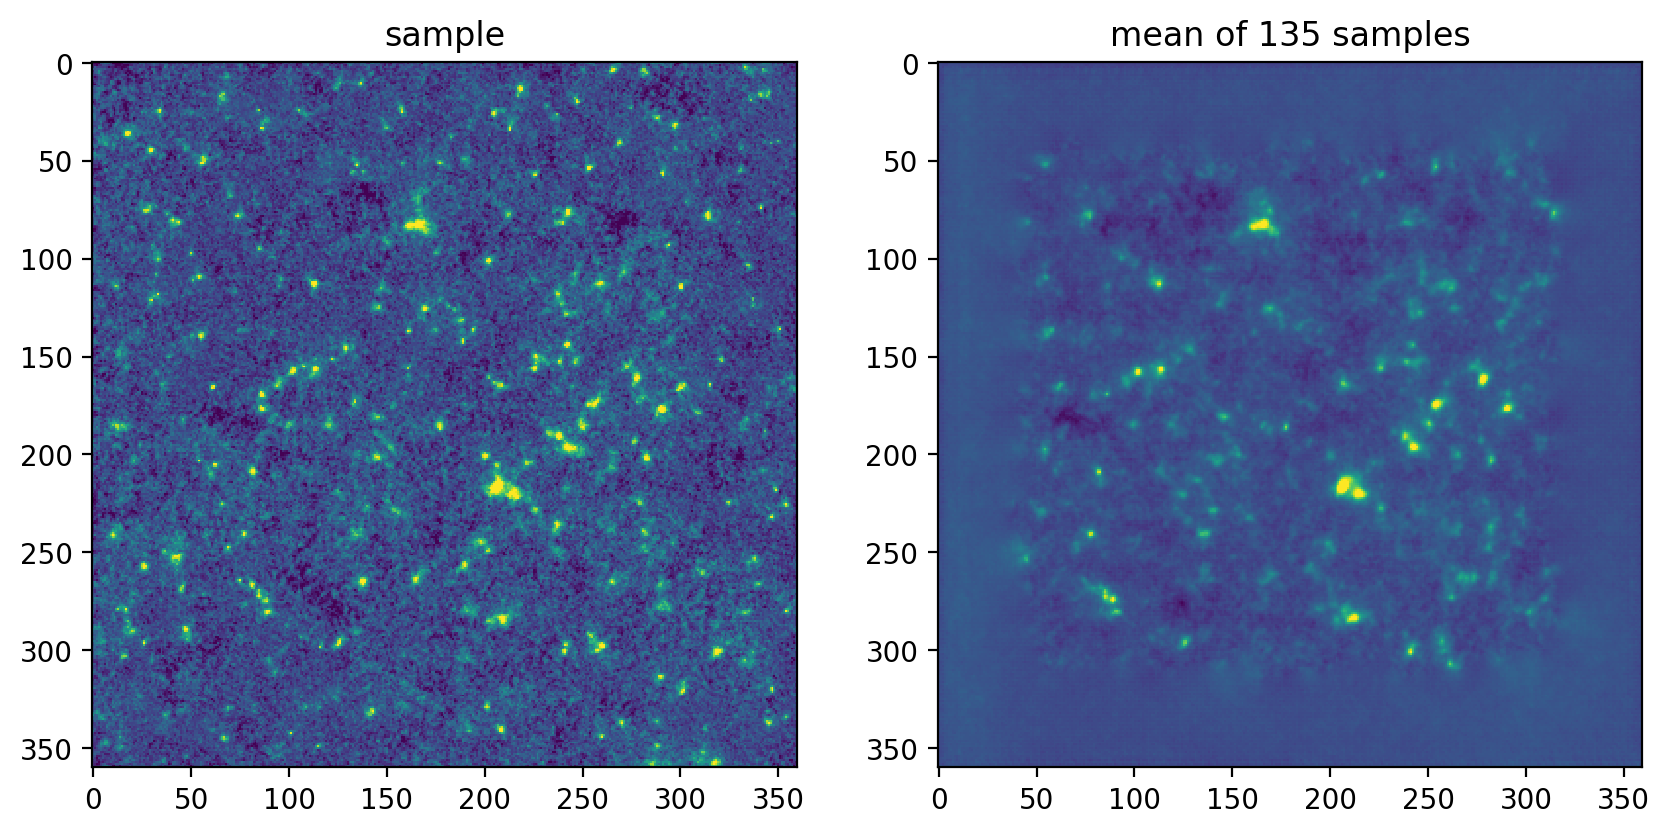

In [45]:
figure(figsize(10,5), dpi=200)
subplot(121)
imshow(s[-1,0,...].reshape(360,360), vmin=-0.05, vmax=0.2)
title('sample')
subplot(122)
imshow(np.mean(s[-1,...], axis=0).reshape(360,360), vmin=-0.05, vmax=0.2)
title('mean of {} samples'.format(s.shape[1]))

## Denoise posterior sample

In [105]:
samples = s[-1,...]
sigma = 0.01 * jnp.ones(samples.shape[0])
batch = {'y':samples.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}

In [106]:
_, res, gaussian_score = score_fn(batch)

In [107]:
res.shape

(135, 360, 360, 2)

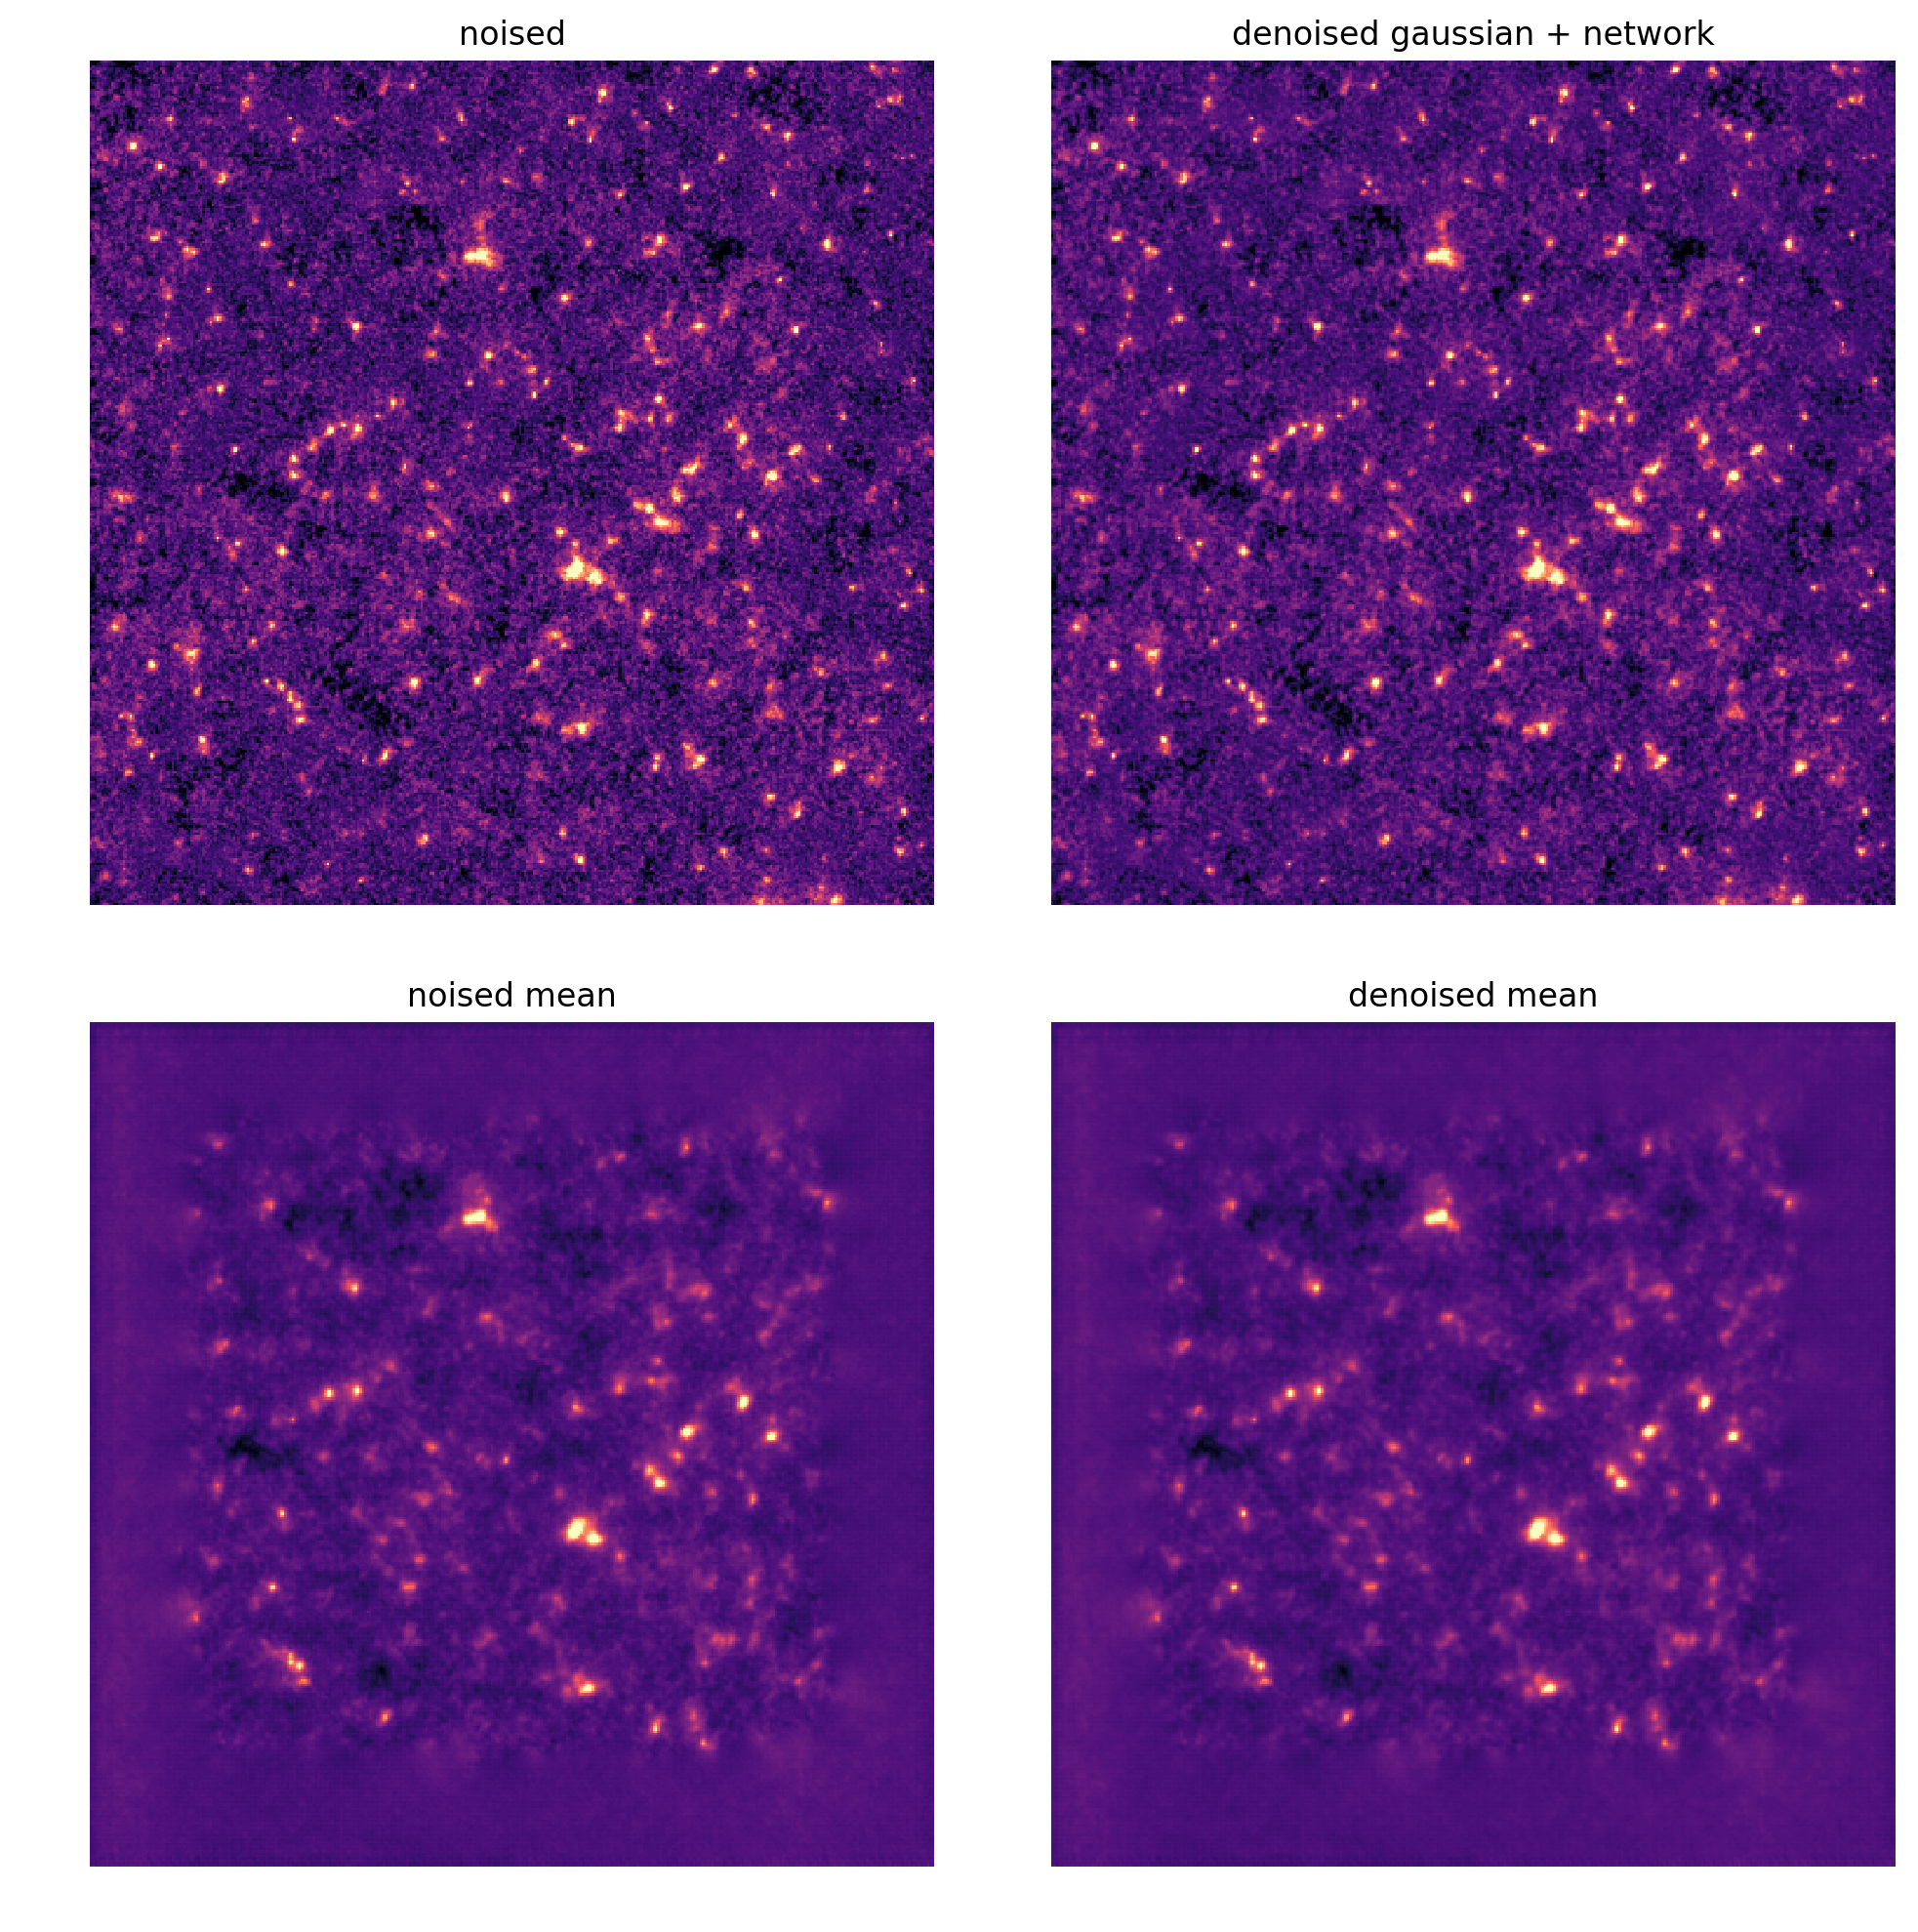

In [108]:
figure(figsize=(10,10), dpi=200)

ind = 0

vmin=-0.05
vmax=0.2
#cmap='viridis'
cmap='magma'

subplot(221)
imshow(batch['y'][ind,...,0],cmap=cmap, vmin=vmin,vmax=vmax)
title('noised')
#colorbar()
axis('off')

subplot(222)
imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap=cmap,vmin=vmin,vmax=vmax)
title('denoised gaussian + network')
axis('off')

sample_denoised = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0])

subplot(223)
imshow(jnp.mean(batch['y'][:,...,0], axis=0),vmin=vmin,vmax=vmax, cmap='magma')
title('noised mean')
#colorbar()
axis('off')

subplot(224)
imshow(jnp.mean(batch['y'][:,...,0] + batch['s'][:,:,:,0]**2 * (res[:,...,0] + gaussian_score[:,...,0]), axis=0),cmap=cmap,vmin=vmin,vmax=vmax)
title('denoised mean')
axis('off')

tight_layout()

Text(0.5,1,'ground truth')

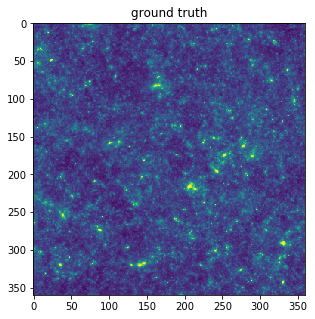

In [109]:
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype(jnp.float32)
imshow(convergence, vmin=vmin, vmax=vmax)
title('ground truth')

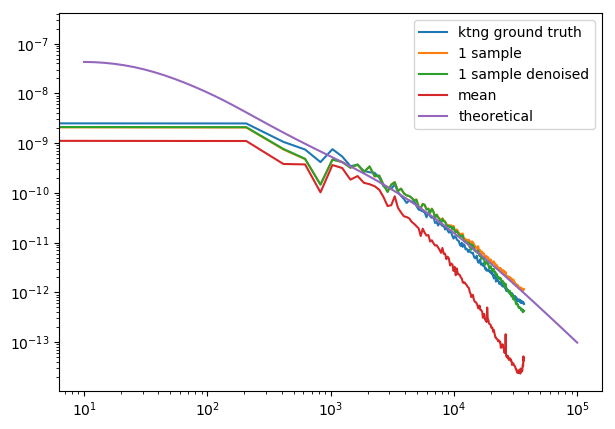

In [110]:
figure(figsize=(7,5), dpi=100)

ell, ps_gt = measure_power_spectrum(convergence, pixel_size)
ps_data_gt = jnp.stack([ell, ps_gt], axis=0)
loglog(ps_data_gt[0,:], ps_data_gt[1,:], label='ktng ground truth')

ell, ps_sample = measure_power_spectrum(samples[ind,...].reshape(360,360), pixel_size)
ps_data_sample = jnp.stack([ell, ps_sample], axis=0)
loglog(ps_data_sample[0,:], ps_data_sample[1,:], label='1 sample')

#sample_denoised
ell, ps_sample = measure_power_spectrum(sample_denoised, pixel_size)
ps_data_sample = jnp.stack([ell, ps_sample], axis=0)
loglog(ps_data_sample[0,:], ps_data_sample[1,:], label='1 sample denoised')

ell, ps_mean = measure_power_spectrum(jnp.mean(samples, axis=0).reshape(360,360), pixel_size)
ps_data_mean = jnp.stack([ell, ps_mean], axis=0)
loglog(ps_data_mean[0,:], ps_data_mean[1,:], label='mean')


loglog(ps_data_th[0,:], ps_data_th[1,:], label='theoretical')

legend()